<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide ResNet 16_2

In [0]:
import tensorflow as tf

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    init = (68, 100,1)

    wrn_16_2 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.0)

    wrn_16_2.summary()

   # plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)


conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 68, 100, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 68, 100, 16)  144         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 68, 100, 16)  64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 68, 100, 16)  0           batch_normalization_52[0][0]     
__________

In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle

import numpy as np

In [0]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()


In [56]:
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [57]:
X = new_data_X.astype('float32')
X[0].shape

(68, 100)

In [9]:
X = list(map(augment_cifar, X))
X = np.array(X)
X.shape

(5722, 32, 32)

In [0]:
img_rows, img_cols = X[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [59]:
X.shape


(5722, 68, 100, 1)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_df = pd.DataFrame(Y_data, columns=['Label'])
y_df['Encoded'] = labelencoder.fit_transform(y_df['Label'])

In [61]:
y_df['Label'].value_counts()

open             1500
closed           1500
partiallyOpen    1376
notVisible       1346
Name: Label, dtype: int64

In [62]:
y_df['Encoded'].value_counts()


2    1500
0    1500
3    1376
1    1346
Name: Encoded, dtype: int64

In [0]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_df['Encoded'])

In [0]:
from tensorflow.keras.optimizers import SGD

EPOCHS = 200
BS = 128

In [0]:
sgd = SGD(lr=0.1, momentum=0.9)

In [66]:
wrn_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")


Finished compiling


In [0]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping


In [0]:
def lr_sch(epoch):
    if epoch < 60:
        return 0.1
    elif epoch < 120:
        return 0.02
    elif epoch < 160:
        return 0.004
    else:
        return 0.0008

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [0]:
import tensorflow
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=2, random_state=42, shuffle=False)
hist_list = []
train_set= []
test_set = []
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    train_set.append(train_index)
    test_set.append(test_index)
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y_cat[train_index], y_cat[test_index]
    hist = wrn16_2.fit_generator(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   callbacks=[lr_scheduler],
                   validation_data=(X_test, y_test),
                   validation_steps=X_test.shape[0] // BS,)
    hist_list.append(hist)

Train Index:  [2861 2862 2863 ... 5719 5720 5721] 

Test Index:  [   0    1    2 ... 2858 2859 2860]
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
22/22 [==============================] - 9s 401ms/step - loss: 2.4788 - acc: 0.3132 - val_loss: 2.7075 - val_acc: 0.2478 - lr: 0.1000
Epoch 2/200
22/22 [==============================] - 7s 302ms/step - loss: 2.3858 - acc: 0.3465 - val_loss: 2.3950 - val_acc: 0.3387 - lr: 0.1000
Epoch 3/200
22/22 [==============================] - 7s 303ms/step - loss: 2.3268 - acc: 0.3417 - val_loss: 2.3503 - val_acc: 0.3443 - lr: 0.1000
Epoch 4/200
22/22 [==============================] - 7s 303ms/step - loss: 2.2811 - acc: 0.3597 - val_loss: 2.2910 - val_acc: 0.3502 - lr: 0.1000
Epoch 5/200
22/22 [==============================] - 7s 304ms/step - loss: 2.2260 - acc: 0.3659 - val_loss: 2.2878 - val_acc: 0.3279 - lr: 0.1000
Epoch 6/200
22/22 [==============================] - 7s 302ms/step - loss: 2.2028 - acc: 0.36

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.33)

In [74]:

hist = wrn_16_2.fit_generator(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   callbacks=[lr_scheduler],
                   validation_data=(X_test, y_test),
                   validation_steps=X_test.shape[0] // BS,)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
29/29 [==============================] - 5s 165ms/step - loss: 2.4583 - acc: 0.3233 - val_loss: 2.3692 - val_acc: 0.3716 - lr: 0.1000
Epoch 2/200
29/29 [==============================] - 4s 142ms/step - loss: 2.3242 - acc: 0.3879 - val_loss: 2.2560 - val_acc: 0.4214 - lr: 0.1000
Epoch 3/200
29/29 [==============================] - 4s 150ms/step - loss: 2.2429 - acc: 0.4016 - val_loss: 2.1912 - val_acc: 0.4383 - lr: 0.1000
Epoch 4/200
29/29 [==============================] - 4s 143ms/step - loss: 2.1608 - acc: 0.4205 - val_loss: 2.3368 - val_acc: 0.3430 - lr: 0.1000
Epoch 5/200
29/29 [==============================] - 4s 143ms/step - loss: 2.0869 - acc: 0.4489 - val_loss: 1.9971 - val_acc: 0.5013 - lr: 0.1000
Epoch 6/200
29/29 [==============================] - 4s 143ms/step - loss: 1.9923 - acc: 0.4964 - val_loss: 1.9794 - val_acc: 0.4844 - lr: 0.1000
Epoch 7/200
29/29 [=============================

In [0]:
wrn28_10.save("model_last.h5")

In [0]:
img = X_train[8]
img.shape

In [0]:
y_train[8]

In [0]:
np.argmax(wrn28_10(image))

In [0]:
y_train_df['Label'])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


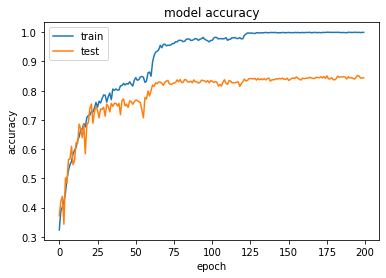

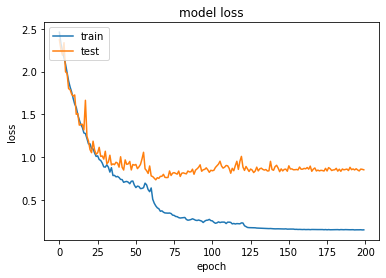

<Figure size 432x288 with 0 Axes>

In [78]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

In [79]:
wrn_16_2.evaluate(X_test,y_test)

60/60 [==============================] - 1s 12ms/step - loss: 0.8555 - acc: 0.8444


[0.8555046319961548, 0.8443620800971985]

In [80]:
wrn_16_2.evaluate(X_train,y_train)

120/120 [==============================] - 1s 12ms/step - loss: 0.1524 - acc: 0.9997


[0.1523597091436386, 0.9997391104698181]